# Music

Data borrowed from here: https://github.com/mcleavey/musical-neural-net/  
http://www.christinemcleavey.com/files/notewise_piano_solo.tar.gz  
http://www.christinemcleavey.com/files/jazz.tar.gz  
http://www.christinemcleavey.com/files/notewise_chamber.tar.gz  

Notebook is a combined implementation from:
https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson3-imdb.ipynb  
https://github.com/mcleavey/musical-neural-net/blob/master/train.py

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *

## Preparing the data

In [3]:
class MusicTokenizer():
    def __init__(self):
        super().__init__()
        self.n_cpus = num_cpus()
        
    def process_text(self, t:str) -> List[str]:
        return t.split(" ")
    
    def _process_all_1(self, texts:Collection[str]) -> List[List[str]]:
        return [self.process_text(t) for t in texts]

    def process_all(self, texts:Collection[str]) -> List[List[str]]:
        "Process a list of `texts`."
        if self.n_cpus <= 1: return self._process_all_1(texts)
        with ProcessPoolExecutor(self.n_cpus) as e:
            return sum(e.map(self._process_all_1, partition_by_cores(texts, self.n_cpus)), [])


In [164]:
path = Path('data/composers/notewise/piano_solo/note_range38/sample_freq12')
path.ls()[:5]

[PosixPath('data/composers/notewise/piano_solo/note_range38/sample_freq12/jazz'),
 PosixPath('data/composers/notewise/piano_solo/note_range38/sample_freq12/ravel'),
 PosixPath('data/composers/notewise/piano_solo/note_range38/sample_freq12/bach'),
 PosixPath('data/composers/notewise/piano_solo/note_range38/sample_freq12/schumann'),
 PosixPath('data/composers/notewise/piano_solo/note_range38/sample_freq12/test1')]

In [5]:
bs=32

In [6]:
if (path/'tmp/itos.pkl').exists():
# if False:
    data = TextLMDataBunch.load(path, bs=bs)
else:
    p = [OpenFileProcessor(), TokenizeProcessor(tokenizer=MusicTokenizer(), chunksize=10), NumericalizeProcessor(vocab=None, max_vocab=500)]

    data = (TextList.from_folder(path, recurse=True, processor=p)
            .random_split_by_pct(0.05, seed=6)
            .label_for_lm()
            .databunch(bs=bs))
    data.save('tmp')
vocab = data.train_ds.vocab
len(data.train_ds), len(data.valid_ds), len(data.train_ds.vocab.itos)

(1798, 94, 110)

It only contains one csv file, let's have a look at it.

In [7]:
t = data.train_ds[0][0]
t.text[:50], t.data

('xxbos wait25 wait25 wait25 wait25 wait25 wait25 wa',
 array([  2,  94,  94,  94, ...,   9,  53,   9, 109]))

In [8]:
data.show_batch()

idx,text
0,xxbos p11 wait5 endp11 wait1 p15 p18 wait6 p15 p18 wait5 endp15 endp18 wait1 p7 wait5 endp7 wait1 p15 p17 wait6 p15 p17 wait5 endp15 endp17 wait1 p11 wait5 endp11 wait1 p15 p18 wait6 p15 p18 wait5 endp15 endp18 wait1 p7 wait5 endp7 wait1 p15 p17 wait6 p15 p17 wait5 endp15 endp17 wait1 p11 wait5 endp11 wait1 p15 p18 wait6 p15 p18 wait5 endp15 endp18 wait1 p7 wait5 endp7 wait1
1,wait1 p6 wait8 p2 endp6 wait2 endp2 wait2 p3 p4 p6 p8 p11 wait3 endp11 wait2 endp3 endp6 endp8 wait3 p3 p6 p8 p11 wait1 p4 wait1 endp3 endp11 wait1 endp6 endp8 wait1 p3 p11 wait3 p6 p8 p11 wait2 endp3 wait3 endp4 endp6 endp8 endp11 wait4 p3 p4 p6 p8 p11 wait5 endp3 endp6 endp8 endp11 wait2 endp4 wait2 p2 p3 p6 p8 p11 wait2 endp2 wait1 p3 p4
2,endp18 wait1 p9 wait5 endp9 wait1 p1 wait6 p1 wait6 p1 wait5 endp1 endp25 endp33 wait1 p11 p23 p32 wait3 endp23 endp32 wait1 p25 p33 wait1 endp11 wait1 p17 endp25 endp33 wait2 p23 p32 wait3 endp17 endp23 endp32 wait1 p21 p25 p30 wait5 endp25 wait1 p17 wait5 endp17 wait1 p11 wait5 endp11 endp21 endp30 wait1 p1 p20 p29 wait5 endp1 endp20 endp29 wait1 p6 p21 p30 wait6 p1 wait1 endp6
3,endp36 wait1 p32 wait5 endp32 wait1 p33 wait5 endp33 wait1 p29 wait5 endp29 wait1 p28 wait11 endp28 wait1 p20 p23 p26 wait11 endp20 endp23 endp26 wait1 p21 p24 wait11 endp21 endp24 wait1 p29 wait11 endp29 wait1 p14 p21 p23 wait11 endp14 wait1 p15 p21 p23 wait11 endp15 endp21 endp23 wait1 p16 p20 p24 wait2 endp24 wait1 p23 wait1 p21 wait2 endp21 p23 wait5 endp16 endp20 endp23 wait1 p4 wait6 p23
4,endp5 endp12 wait3 p15 wait3 p9 endp15 wait3 endp9 p12 wait3 endp12 wait3 p3 p17 wait3 endp17 p21 wait3 p1 endp21 p22 wait1 endp3 wait4 endp22 wait1 p17 wait1 endp1 wait2 p0 endp17 p24 wait3 p17 wait2 endp24 wait1 endp17 wait1 endp0 wait2 p10 p25 wait3 p22 wait3 endp22 wait2 p20 wait3 endp20 wait1 p18 wait3 endp10 endp18 p20 wait3 endp20 wait1 endp25 wait1 p23 wait3 endp23 wait1 p17 wait3


## Language model

Note that language models can use a lot of GPU, so you may need to decrease batchsize here.

Now let's grab the full dataset for what follows.

This is where the unlabelled data is going to be useful to us, as we can use it to fine-tune our model. Let's create our data object with the data block API (next line takes a few minutes).

In [9]:
# data_lm = (TextList.from_folder(path)
#            #Inputs: all the text files in path
#             .filter_by_folder(include=['train', 'test', 'unsup']) 
#            #We may have other temp folders that contain text files so we only keep what's in train and test
#             .random_split_by_pct(0.1)
#            #We randomly split and keep 10% (10,000 reviews) for validation
#             .label_for_lm()           
#            #We want to do a language model so we label accordingly
#             .databunch(bs=bs))
# data_lm.save('tmp_lm')

We have to use a special kind of `TextDataBunch` for the language model, that ignores the labels (that's why we put 0 everywhere), will shuffle the texts at each epoch before concatenating them all together (only for training, we don't shuffle for the validation set) and will send batches that read that text in order with targets that are the next word in the sentence.

The line before being a bit long, we want to load quickly the final ids by using the following cell.

We can then put this in a learner object very easily with a model loaded with the pretrained weights. They'll be downloaded the first time you'll execute the following line and stored in `~/.fastai/models/` (or elsewhere if you specified different paths in your config file).

In [9]:
learn = language_model_learner(data, drop_mult=1, clip=.5, bptt=200)

In [10]:
learn = learn.to_fp16()

In [ ]:
learn.lr_find(num_it=1000)

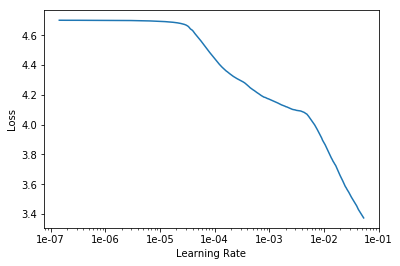

In [ ]:
learn.recorder.plot(skip_end=15)

In [ ]:
# From old code
# learner.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)    # Applying regularization
# learner.clip=0.3                                          # Clip the gradients  

In [12]:
learn.fit_one_cycle(1, 2e-3, moms=(0.7,0.5))

epoch,train_loss,valid_loss,accuracy
1,1.402518,1.259624,0.612284


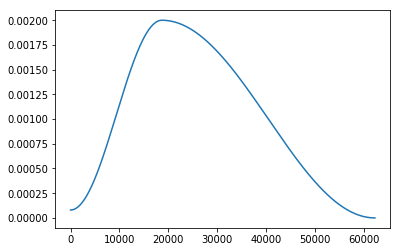

In [13]:
learn.recorder.plot_lr()

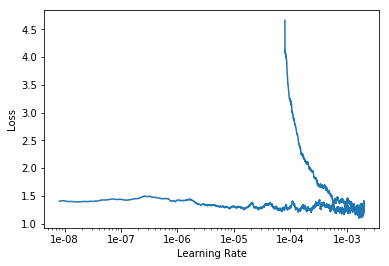

In [14]:
learn.recorder.plot()

In [15]:
learn.save('first_run')

In [16]:
learn.load('fit_head');

In [17]:
out = learn.pred_batch()

In [34]:
learn.show_results(rows=5, max_len=25)

text,target,pred
xxbos wait24 p32 wait3 endp32 wait9 p16 p32 wait5 endp16 endp32 wait7 p18 p33 wait5 endp18 endp33 wait7 p20 p35 wait5 endp20 endp35 wait7 p20,wait8 endp20 endp35 wait4 p18 p33 wait5 endp18 endp33 wait19 p15 p30 wait5 endp15 endp30 wait7 p16 p32 wait5 endp16 endp32 wait7 p18 p33 wait5,wait5 endp20 endp35 wait4 p20 p30 wait5 endp18 endp33 wait1 p18 p30 wait5 endp15 endp30 wait1 p16 p32 wait5 endp16 endp32 wait1 p20 p30 wait5
endp23 endp30 wait1 p9 p11 wait5 endp9 wait1 p4 p7 p11 p16 wait6 p7 p11 p16 wait5 endp7 wait1 p11 p16 p19 wait5 endp16 endp19,p11 p18 p21 wait5 endp18 endp21 wait1 p4 p11 p16 p19 p23 wait5 endp11 endp19 endp23 wait1 p16 endp16 p18 endp18 p21 endp21 wait2 p16,p4 p23 p23 wait5 endp11 endp21 wait1 p4 p7 p19 p19 wait5 wait5 endp4 endp16 endp23 wait1 p4 p21 p19 endp18 p22 endp21 wait6 endp4
wait5 endp16 wait1 p14 wait5 endp19 wait1 p9 wait5 endp9 wait1 p19 wait5 endp14 wait1 p12 wait5 endp19 wait1 p17 wait5 endp17 wait1 p19 wait5,wait1 p11 wait5 endp19 wait1 p16 wait5 endp16 wait1 p19 wait5 endp11 wait1 p9 wait5 endp19 wait1 p14 wait5 endp14 wait1 p19 wait5 endp9 wait1,endp19 p14 wait5 endp5 wait1 p17 wait5 endp16 wait1 p17 wait5 endp19 endp19 p12 wait5 endp9 wait1 p17 wait5 endp14 wait1 p12 wait5 endp19 endp19
endp16 endp21 endp28 wait1 p19 p22 p24 wait5 endp19 endp22 wait1 p12 p18 p21 wait2 endp12 endp18 endp21 wait4 p12 p18 p21 wait2 endp12 endp18,wait4 p4 p12 wait2 endp4 endp12 wait4 p33 wait11 endp33 wait1 p18 p21 p24 wait2 endp18 endp21 wait4 p12 p17 p20 wait2 endp12 endp17 endp20,wait4 p12 wait2 p19 endp4 endp12 wait4 p15 wait2 endp33 wait1 p12 p21 p24 p27 endp18 endp21 endp24 p18 wait2 p21 wait2 endp12 endp17 endp20
endp8 wait1 p10 wait1 p11 wait1 endp10 wait1 endp11 p13 p19 endp19 p31 endp31 wait2 p11 endp13 wait1 p10 wait1 endp11 wait1 endp10 wait1 p8,endp20 p32 endp32 wait2 endp8 wait4 p3 p32 endp32 wait2 endp3 p5 wait1 p7 wait1 endp5 wait1 endp7 wait1 p8 p35 endp35 wait2 endp8 wait1,wait2 p22 endp32 wait2 endp8 wait1 p10 endp3 endp32 wait1 endp3 p8 wait1 p8 p31 endp5 wait1 endp7 wait1 p8 wait2 wait2 wait2 endp8 wait1


In [35]:
seed = 'xxbos wait24 p32 wait3 endp32 wait9 p16 p32 wait5 endp16 endp32 wait7 p18 p33 wait5 endp18 endp33 wait7 p20 p35 wait5 endp20 endp35 wait7 p20'

In [46]:
pred_out = learn.predict(seed, n_words=500)

In [72]:
seed_2 = 'wait4 p28 wait5 endp28 p30 wait3 p27 wait4 p28 endp30 p32 wait1 endp27 wait1 p26 wait5 endp28 endp32 wait1 p25 p30 p33 wait1 endp26 wait13 endp25 endp30 endp33 wait4 p23 p28 p32 p35 wait3 endp28 endp32 endp35 wait5 endp23 wait2 p21 p25 p29 p33 p37 wait8 endp21 wait4 p9 wait8 endp33 endp37 wait3 endp9 wait3 endp25 endp29 wait12 p11 p14 p16 p18 p21 p23 wait2 p9 wait6 endp11 endp14 endp16 endp18 wait2 endp9 wait1 endp21 endp23 wait15 p19 p25 p30 p35 wait2 endp30 endp35 wait1 endp19 endp25 wait4 p18 p23 p28 p33 wait2 endp28 endp33 wait1 endp23 wait3 p32 wait1'

In [112]:
pred_out_2 = learn.predict(subsample, n_words=250)

### Testing

In [163]:
file

PosixPath('data/composers/notewise/piano_solo/note_range38/sample_freq12/bach/bwv792.txt')

In [174]:
file = path.ls()[2].ls()[8]

with open(file, 'r') as f:
    txt_out = f.read()
notes = txt_out.split(' ')
subsample = ' '.join(notes[:500])

In [167]:
subsample

'p18 p30 wait5 endp18 endp30 wait1 p29 wait2 endp29 wait1 p30 wait2 endp30 wait1 p17 p32 wait5 endp17 endp32 wait1 p30 wait2 endp30 wait1 p29 wait2 endp29 wait1 p15 p30 wait5 endp15 wait7 p10 wait2 endp30 wait1 p32 wait2 endp10 endp32 wait1 p29 wait2 endp29 wait1 p30 wait2 endp30 wait1 p11 p32 wait2 endp32 wait1 p25 wait2 endp11 endp25 wait1 p34 wait2 endp34 wait1 p25 wait2 endp25 wait1 p13 p35 wait2 endp35 wait1 p25 wait2 endp13 endp25 wait1 p37 wait5 endp37 wait1 p6 p34 endp34 p35 endp35 wait3 p32 p34 endp34 wait2 endp6 endp32 wait1 p18 p30 wait2 endp30 wait1 p32 wait2 endp18 endp32 wait1 p17 p34 wait2 endp34 wait1 p36 wait2 endp17 endp36 wait1 p15 p37 wait2 endp37 wait3 endp15 wait1 p13 p25 wait5 endp13 endp25 wait1 p24 p32 wait2 endp24 wait1 p25 wait2 endp25 wait1 p24 p27 wait2 endp32 wait3 endp24 endp27 wait1 p25 wait2 endp25 wait1 p24 wait2 endp24 wait1 p22 p25 p37 wait2 endp37 wait1 p36 wait2 endp22 endp36 wait1 p34 wait2 endp34 wait1 p32 wait2 endp32 wait1 p17 p37 wait2 endp25 

In [122]:
pred_out_2

'p25 wait8 p27 wait4 p29 wait1 endp27 wait4 endp29 wait3 p30 wait4 p32 wait1 endp30 wait4 endp32 wait1 p34 wait5 endp25 endp34 wait1 p24 p32 wait5 endp32 wait1 p34 wait5 endp34 wait1 p30 wait5 endp24 endp30 wait1 p25 p29 p32 wait5 endp32 wait1 p34 wait5 endp34 wait1 p36 wait5 endp25 endp36 wait1 p22 p37 wait5 endp37 wait12 endp22 endp29 wait1 p27 p31 wait10 p37 wait5 endp37 wait2 endp27 endp31 wait1 p20 p32 p36 wait4 p22 wait1 endp20 wait4 endp22 p24 wait5 endp24 wait2 p25 p34 wait1 endp36 wait4 endp25 p27 wait5 endp27 wait2 p29 wait5 p27 endp29 p30 wait2 endp32 wait3 endp27 wait2 p29 wait5 p25 endp29 wait5 endp25 wait1 p24 p32 endp34 wait5 endp24 wait1 p25 wait5 endp25 wait1 p27 wait5 endp27 endp30 wait1 p25 p29 wait5 endp25 wait1 p27 wait5 p24 endp27 wait5 endp24 wait1 endp32 wait1 p22 p30 wait5 endp22 p24 wait5 endp24 wait2 p25 wait5 p24 endp25 p27 endp29 wait5 endp24 wait2 p25 wait5 p22 endp25 wait4 p20 p29 wait1 endp22 wait1 endp30 wait3 endp20 wait3 p22 wait4 p24 wait1 endp22 wai

### Generate from predictions

In [168]:
from utils import *

In [40]:
# stream = 'wait24 p32 wait3 endp32 wait9 p16 p32 wait5 endp16 endp32 wait7 p18 p33 wait5 endp18 endp33 wait7 p20 p35'

In [123]:
pred_format = pred_out_2.replace('xxbos ', '')

In [170]:
out_dir = Path('tmp_out')

In [189]:
midi_file.unlink()

In [190]:
file_sample = str(path.ls()[2].ls()[8])
note_offset= 45 if 'note_range38' in file_sample else 33
sample_freq = 12 if 'sample_freq12' in file_sample else 4

In [191]:
result = write_mid_mp3_wav(subsample, fname='testfile_2.mid', 
                           sample_freq=sample_freq, note_offset=note_offset, 
                           out=out_dir, chordwise=False)





In [125]:
# result = write_mid_mp3_wav(pred_format[len(subsample):], fname='testfile_2.mid', 
#                            sample_freq=12, note_offset=38, 
#                            out=out_dir, chordwise=False)





In [192]:
midi_file = out_dir/'testfile_2.mid'; midi_file.exists()

True

In [193]:
from music21 import *

In [208]:
mf = midi.MidiFile()
mf.open(midi_file)
mf.read()
mf.close()
s = midi.translate.midiFileToStream(mf)

In [210]:
s.show('midi')

In [137]:
path = Path('data/example_sound_files')

In [140]:
midi_file = path/'happy_birthday.mid'

In [141]:
mf = midi.MidiFile()
mf.open(midi_file)
mf.read()
mf.close()
s = midi.translate.midiFileToStream(mf)

In [143]:
s

<music21.stream.Score 0x7f2df45e6898>

In [207]:
from IPython.display import Image
Image(filename=str(s.write('lily.png')))

LilyTranslateException: Cannot translate an object of zero duration <music21.duration.Duration 0.0>

In [198]:
%debug

> /home/ubuntu/anaconda3/envs/musical_neural_net/lib/python3.7/site-packages/music21/lily/translate.py(1562)lyMultipliedDurationFromDuration()
   1560         if number_type == 0:
   1561             raise LilyTranslateException(
-> 1562                 'Cannot translate an object of zero duration %s' % durationObj)
   1563 
   1564         if number_type < 1:

ipdb> number_type
0.0
ipdb> noteOrRest.duration
*** NameError: name 'noteOrRest' is not defined
ipdb> up
> /home/ubuntu/anaconda3/envs/musical_neural_net/lib/python3.7/site-packages/music21/lily/translate.py(1294)lySimpleMusicFromNoteOrRest()
   1292                 simpleElementParts.append("r ")
   1293 
-> 1294         lpMultipliedDuration = self.lyMultipliedDurationFromDuration(noteOrRest.duration)
   1295         simpleElementParts.append(lpMultipliedDuration)
   1296 

ipdb> noteOrRest
<music21.note.Note C#>
ipdb> noteOrRest.duration
<music21.duration.Duration 0.0>
ipdb> quit


In [229]:
[x for x in s]

[<music21.stream.Part 0x7f2d9db902e8>]

In [231]:
s_flat = s.flat

In [237]:
[(n,n.duration) for n in s_flat.notes]

[(<music21.note.Note F>, <music21.duration.Duration 0.25>),
 (<music21.note.Note C#>, <music21.duration.Duration 1.0>),
 (<music21.note.Note F>, <music21.duration.Duration 0.25>),
 (<music21.note.Note G#>, <music21.duration.Duration 0.25>),
 (<music21.note.Note C#>, <music21.duration.Duration 0.5>),
 (<music21.note.Note F#>, <music21.duration.Duration 0.25>),
 (<music21.note.Note E->, <music21.duration.Duration 1.0>),
 (<music21.note.Note C>, <music21.duration.Duration 0.25>),
 (<music21.note.Note B->, <music21.duration.Duration 0.25>),
 (<music21.chord.Chord F5 F#5>, <music21.duration.Duration 0.0>),
 (<music21.note.Note F>, <music21.duration.Duration 1.5>),
 (<music21.note.Note G#>, <music21.duration.Duration 1.25>),
 (<music21.note.Note G#>, <music21.duration.Duration 0.25>),
 (<music21.note.Note C>, <music21.duration.Duration 0.25>),
 (<music21.note.Note C#>, <music21.duration.Duration 2.75>),
 (<music21.note.Note F>, <music21.duration.Duration 0.5>),
 (<music21.note.Note F#>, <mus

In [228]:
ps = s[0]

In [230]:
[x for x in ps]

[<music21.instrument.Piano Piano>,
 <music21.instrument.Piano Piano>,
 <music21.stream.Voice 0x7f2d9db64ac8>,
 <music21.stream.Voice 0x7f2d9db64b38>,
 <music21.stream.Voice 0x7f2d9db64b70>,
 <music21.stream.Voice 0x7f2d9db64ba8>]

In [227]:
ps.notes

<music21.stream.iterator.StreamIterator for Part:0x7f2d9db902e8 @:6>

In [226]:
[x for x in ps[0]]

TypeError: 'Piano' object is not iterable

In [212]:
s[0].notes

<music21.stream.iterator.StreamIterator for Part:0x7f2d9db902e8 @:0>

In [213]:
[n for n in s[0].notes]

[]

In [199]:
[n for n in s]

[<music21.stream.Part 0x7f2df4f5db38>]

### Previous notebook cells

To complete the fine-tuning, we can then unfeeze and launch a new training.

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,3.949835,3.892163,0.309857
2,3.863976,3.823716,0.319508
3,3.827637,3.776987,0.325163
4,3.782025,3.738658,0.329756
5,3.704519,3.705750,0.333159
6,3.658038,3.682820,0.335856
7,3.608049,3.662626,0.338366
8,3.552923,3.648938,0.340119
9,3.518708,3.642814,0.340864
10,3.480421,3.641818,0.340905


In [ ]:
learn.save('fine_tuned')

How good is our model? Well let's try to see what it predicts after a few given words.

In [ ]:
learn.load('fine_tuned');

In [ ]:
TEXT = "i liked this movie because"
N_WORDS = 40
N_SENTENCES = 2

In [ ]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

i liked this movie because it was clearly a movie . xxmaj so i gave it a 2 out of 10 . xxmaj so , just say something . xxbos xxmaj this is a really stunning picture , light years off of the late xxmaj
i liked this movie because it would be a good one for those who like deep psychological and drama and you can go see this movie if you like a little slow motion and some magic should n't be there . i would give it


We have to save the model but also it's encoder, the part that's responsible for creating and updating the hidden state. For the next part, we don't care about the part that tries to guess the next word.

In [ ]:
learn.save_encoder('fine_tuned_enc')